In [1]:
#follow the command to install any package:
#!pip install torch


### Install Packages

In [2]:
#Import the librarry

import numpy as np  # For mathematical computations and array operations
import torch  # For deep learning, tensor computations, and GPU acceleration
from torch.utils.data import Dataset, DataLoader, ConcatDataset  # For handling and loading datasets efficiently
import glob  # For file searching and pattern matching in directories to get the images
import matplotlib.pyplot as plt  # For data visualization and plotting graphs and see the model expriance in vizualize
from sklearn.metrics import confusion_matrix, accuracy_score  # For evaluating model performance, mainly Conf_Matrix
import random  # For generating random numbers and shuffling data
import cv2  # For image processing and computer vision tasks
import sys  # For system-specific parameters and functions, such as handling command-line arguments


### Reading the images:



##### Import the data from :https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection?resource=download




In [3]:
tumor = []

#Matches .png, .jpeg, .jpg, .JPG, .JPEG, .PNG (case-insensitive).

    #[pPjJ] → Matches p, P, j, or J (for png, jpg, jpeg).

    #[nNpP]* → Matches optional n, N, or p, P (for png, jpeg).

    #[gG] → Ensures it ends with g or G.

path = './archive/brain_tumor_dataset/yes/*.[pPjJ][nNpP]*[gG]' 

for f in glob.iglob(path):
    img = cv2.imread(f) # Reading the each image from the path
    
    #Since the data has different dimension, we have to have conssistant dimensions.
    #Let's fix it 
    img = cv2.resize(img, (128,128)) # the dimension of the image set or resize  to 128x128pxl
   
    #Not essentiall but nice to have conventionally 
    b, g, r = cv2.split(img) # spliting the image in blue, green, and red Channals
    img = cv2.merge([r, g, b]) # Then Merge by red, green, blue (RGB) order
    
    tumor.append(img) # Append the img to tumor list 
    
print ("Tumor count:",len(tumor))


healthy=[]

for f in glob.iglob("./archive/brain_tumor_dataset/no/*.[pPjJ][nNpP]*[gG]"):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128)) 
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    healthy.append(img)

print ("Healthy count:", len(healthy))

Tumor count: 155
Healthy count: 98


In [4]:
#Check the size of the image
for i in tumor[1:5]:
    print("This are the sape of the image:", i.shape)
#128 by 128 dimension by 3 channals (RGB)

This are the sape of the image: (128, 128, 3)
This are the sape of the image: (128, 128, 3)
This are the sape of the image: (128, 128, 3)
This are the sape of the image: (128, 128, 3)


In [5]:
#Convert to array
healthy = np.array(healthy)
tumor = np.array(tumor)


In [6]:
print(tumor.shape)
print(healthy.shape)
# For example: For healthy we have 155 image, with 3 channals in dimension of 128 x128 pxl

(155, 128, 128, 3)
(98, 128, 128, 3)


In [7]:
ALL = np.concatenate((healthy, tumor))
print(ALL.shape) # the image joined and become 155 + 98 = 253.

(253, 128, 128, 3)


In [8]:
# Select three random image/number between 0 to 4 [among five indeces value] using np.random.choice.
np.random.choice(5, 3, replace = False) #replace Helps that are not duplicate the same number at the same time. 

array([2, 0, 3])

### Visualize the MRI image

AxesImage(shape=(128, 128, 3))


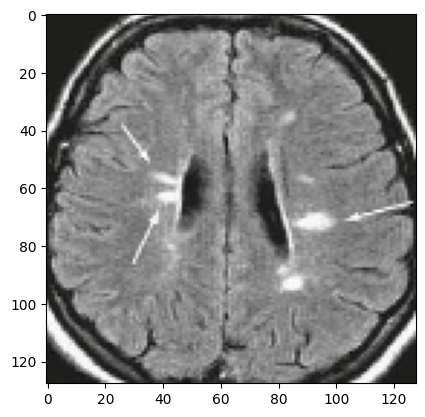

In [9]:
print(plt.imshow(healthy[0])) # Healthy Brain Image

AxesImage(shape=(128, 128, 3))


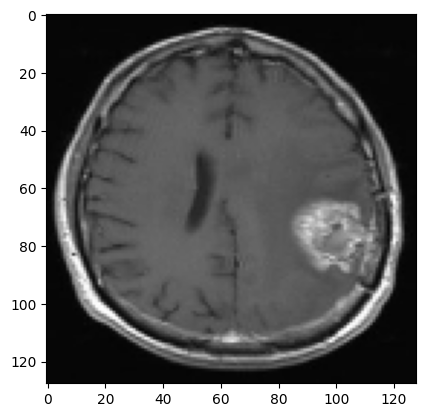

In [10]:
print(plt.imshow(tumor[0])) # Healthy Brain Image

In [11]:
# Let's Create a function that can pull 5 random image from the image data and shows in order with two classifications 

def plot_random(healthy, tumor, num = 5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace = False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace = False)]

    plt.figure(figsize = (16,9))
    for i in range(num):
        plt.subplot(1, num, i+1) # i+1 because we can not plot indeces 0, so we can pull the first 1 by adding 1 in i.
        plt.title ("healthy")
        plt.imshow(healthy_imgs[i])

    plt.figure(figsize = (16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title ("Tumor")
        plt.imshow(tumor_imgs[i])
   
   

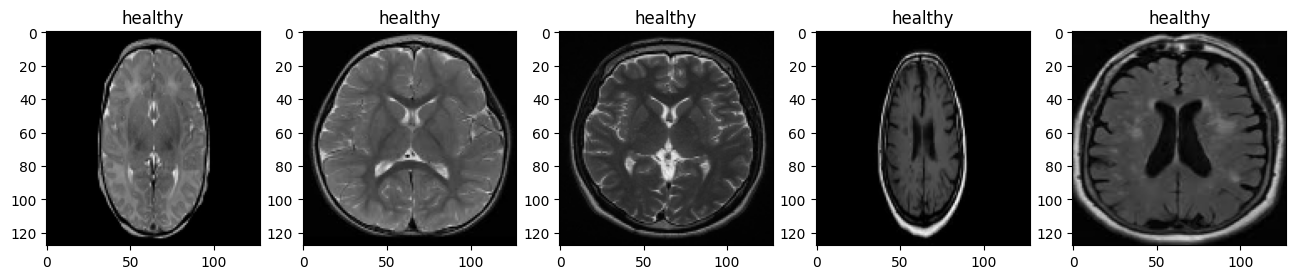

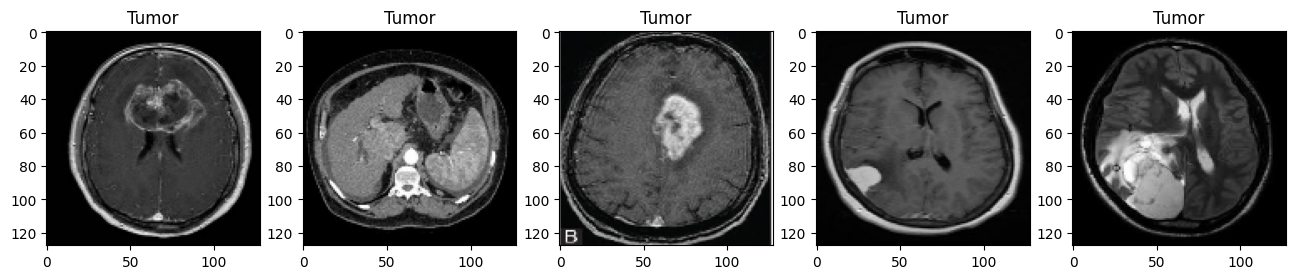

In [12]:
plot_random(healthy, tumor, num = 5)

In [13]:
# Let's Create torch data set from the image

#### Torch DataSets

In [14]:
# We have to overide or simply creating new module/class some class in pytorch! To do this Let's see an example:

class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

# Any assigned dataset from this class can override add as concatenate two data set. we can also modify __getitem__ by replacing 
# "raise NotImplementedError" with some function like self.x[index], you might get some result. The point is we have to ovveride the class, or create a new 
# class from the above dataset(). watch: https://www.youtube.com/watch?v=uvvuDjzjKio&list=PL5foUFuneQnratPPuucpVxWl4RlqueP1u&index=7 



##### Any assigned dataset from this class can override add as concatenate two data set. we can also modify __getitem__ by replacing  "raise NotImplementedError" with some function like self.x[index], you might get some result. The point is we have to ovveride the class, or create a new  class from the above dataset(). 

##### With bing that said, let's Create a Customized Pytorch Class!

### Pythorch Customized Class!

In [15]:
#This calss contain everything and access it and implemented automatically, insted we can finish everything outside and pass the data to the class at the end
class MRI(Dataset):
    
    def __init__(self):
        
        tumor = []
        path = './archive/brain_tumor_dataset/yes/*.[pPjJ][nNpP]*[gG]' 

        for f in glob.iglob(path):
            img = cv2.imread(f) # Reading the each image from the path
            
            #Since the data has different dimension, we have to have conssistant dimensions.
            #Let's fix it 
            img = cv2.resize(img, (128,128)) # the dimension of the image set or resize  to 128x128pxl
           
            #Not essentiall but nice to have conventionally 
            b, g, r = cv2.split(img) # spliting the image in blue, green, and red Channals
            img = cv2.merge([r, g, b]) # Then Merge by red, green, blue (RGB) order
            
            tumor.append(img) # Append the img to tumor list 
            
        #print ("Tumor count:",len(tumor))
        
        
        healthy=[]
        
        for f in glob.iglob("./archive/brain_tumor_dataset/no/*.[pPjJ][nNpP]*[gG]"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            healthy.append(img)
        
        #print ("Healthy count:", len(healthy))

        #Our Image is here in array with type of float
        healthy = np.array(healthy, dtype = np.float32)
        tumor = np.array(tumor, dtype = np.float32)


        #Our labels (0,1) is here in array with type of float.
        tumor_labels = np.ones(tumor.shape[0], dtype = np.float32) # Make it np.ones (1's) each image in tumor
        healthy_labels = np.zeros(healthy.shape[0], dtype = np.float32) # Make it np.zeros (0's) each image in tumor, it's fine to have float

        # We are going to self function for concatenate.
        # axis helps to add the first tumor on top of healthy, which make it (155, 128, 128) + (98, 128, 128) = (243, 128, 128)
        self.images = np.concatenate((tumor, healthy), axis = 0) 
        self.labels = np.concatenate((tumor_labels, healthy_labels), axis = 0)

    
    def __len__ (self):
        return self.images.shape[0] # we are creating like global len() func by returning only self.image.shape[0], which is the first element of shape tuple.
   
    
    def __getitem__(self, index):
        sample = {"images":self.images[index], "label": self.labels[index]} #Creating dict assists to pass two argument when index lodded to the class.
        return sample

    def normalize(self):
        self.images = self.images/255.0


In [16]:
mri = MRI()


In [17]:
#Normalize everything between 0 and 1
#mri.normalize()